## Installing the required Libraries

In [1]:
!pip install opencv-python-headless mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 16.8 MB/s eta 0:00:00


## Loading the Dataset From Kaggle

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("niharika41298/yoga-poses-dataset")

print("Path to dataset files:", path)

100%|██████████| 288M/288M [00:15<00:00, 19.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/niharika41298/yoga-poses-dataset/versions/1


In [3]:
import os
os.listdir("/root/.cache/kagglehub/datasets/niharika41298/yoga-poses-dataset/versions/1/DATASET/TEST")

['goddess', 'tree', 'plank', 'downdog', 'warrior2']

## Preparing the Data for the model training  
### All the images that are present in the test and the train data are converted into their landmark forms which are 33 landmarks features for one image each with 3 (x,y,and z) axis value so one image will be represented as 99 features or columns containing the landmark values.  
### The labels have been taken from the folder name which contains the image and have been encoded using the label encoding.  
### This Step Skips the Image for which Mediapipe is unable to detect the Body Landmarks.

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
from albumentations import (
    HorizontalFlip, ShiftScaleRotate, RandomBrightnessContrast, GaussianBlur, Compose
)

# Initialize MediaPipe Pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Define paths for your dataset
train_dir = '/root/.cache/kagglehub/datasets/niharika41298/yoga-poses-dataset/versions/1/DATASET/TRAIN'  # Path to training data
test_dir = '/root/.cache/kagglehub/datasets/niharika41298/yoga-poses-dataset/versions/1/DATASET/TEST'   # Path to testing data

# Dynamically extract pose labels based on folder names
pose_labels = sorted(os.listdir(train_dir))
label_to_index = {label: idx for idx, label in enumerate(pose_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# Define augmentation pipeline
augmentation_pipeline = Compose([
    HorizontalFlip(p=0.5),
    ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    GaussianBlur(blur_limit=3, p=0.3)
])

# Function to apply augmentations
def augment_image(image):
   
    augmented = augmentation_pipeline(image=image)
    return augmented['image']

# Function to extract landmarks from an image
def extract_landmarks(image_path):
   
    try:
        image = cv2.imread(image_path)
        if image is None:
            return None  # Skip invalid images

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        results = pose.process(image_rgb)

        # If landmarks are found, flatten and return them
        if results.pose_landmarks:
            landmarks = []
            for landmark in results.pose_landmarks.landmark:
                landmarks.extend([landmark.x, landmark.y, landmark.z])  # Extract (x, y, z)
            return np.array(landmarks).flatten()  # Flatten landmarks to a 1D vector
        else:
            return None
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Function to process a dataset directory with augmentation
def process_dataset_with_augmentation(directory, label_to_index, augmentations=5):
   
    landmarks_data = []
    labels_data = []

    for label in os.listdir(directory):
        pose_folder = os.path.join(directory, label)
        if not os.path.isdir(pose_folder):
            continue  # Skip if not a directory

        for image_name in os.listdir(pose_folder):
            image_path = os.path.join(pose_folder, image_name)
            original_landmarks = extract_landmarks(image_path)

            if original_landmarks is not None:
                # Add original image's landmarks and label
                landmarks_data.append(original_landmarks)
                labels_data.append(label_to_index[label])

                # Perform augmentations
                image = cv2.imread(image_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                for _ in range(augmentations):  # Generate augmented samples
                    augmented_image = augment_image(image=image_rgb)
                    augmented_landmarks = extract_landmarks(augmented_image)

                    if augmented_landmarks is not None:
                        landmarks_data.append(augmented_landmarks)
                        labels_data.append(label_to_index[label])

    return np.array(landmarks_data), np.array(labels_data)

# Process augmented training and testing datasets
print("Processing training data with augmentation...")
X_train, y_train = process_dataset_with_augmentation(train_dir, label_to_index, augmentations=5)
print(f"Training data size (with augmentation): {X_train.shape}")

print("Processing testing data...")
X_test, y_test = process_dataset_with_augmentation(test_dir, label_to_index, augmentations=0)
print(f"Testing data size: {X_test.shape}")

# Save the true labels for future use
print("\nTrue Labels for Encoded Indices:")
for idx, label in index_to_label.items():
    print(f"{idx}: {label}")


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:214: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


Streaming output truncated to the last 5000 lines.
  [224 213 214]]

 [[211 166 144]
  [205 160 137]
  [205 160 137]
  ...
  [225 214 215]
  [225 215 215]
  [225 215 214]]

 [[198 154 133]
  [196 150 129]
  [202 157 135]
  ...
  [225 215 213]
  [226 217 214]
  [227 218 215]]]: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'imread'
> Overload resolution failed:
>  - Expected 'filename' to be a str or path-like object
>  - Expected 'filename' to be a str or path-like object
>  - Expected 'filename' to be a str or path-like object

Error processing [[[248 244 233]
  [248 244 233]
  [248 244 233]
  ...
  [214 206 195]
  [214 206 195]
  [213 205 194]]

 [[248 246 234]
  [248 246 234]
  [248 246 234]
  ...
  [214 206 195]
  [214 206 195]
  [214 206 195]]

 [[248 246 234]
  [248 246 234]
  [248 246 234]
  ...
  [215 207 196]
  [214 206 195]
  [214 206 195]]

 ...

 [[ 98  72  68]
  [ 94  69  65]
  [ 94  70  67]
  ...
  [125 108 101]
  [123 106  99]
  [120 103  96]]

 [[ 89  63  60]

In [5]:
X_train.shape

(959, 99)

## Model Training

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models


model = models.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using the GPU
with tf.device('/GPU:0'):  # This ensures the model training uses the GPU
    history=model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")
print(f"Test loss: {loss}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.3934 - loss: 1.4840 - val_accuracy: 0.5392 - val_loss: 1.1951
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5630 - loss: 1.1532 - val_accuracy: 0.5945 - val_loss: 0.9920
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6132 - loss: 0.9903 - val_accuracy: 0.6382 - val_loss: 0.9235
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6264 - loss: 0.9459 - val_accuracy: 0.7074 - val_loss: 0.8318
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6883 - loss: 0.8590 - val_accuracy: 0.7074 - val_loss: 0.7835
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7246 - loss: 0.8073 - val_accuracy: 0.7281 - val_loss: 0.7487
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6996 - loss: 0.7746 - val_accuracy: 0.7949 - val_loss: 0.7048
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7177 - loss: 0.7169 - val_accuracy: 0.8088 - val_loss

### Saving the model.

In [ ]:
model.save("yoga_pose.keras")

### Plotting the Loss Curve

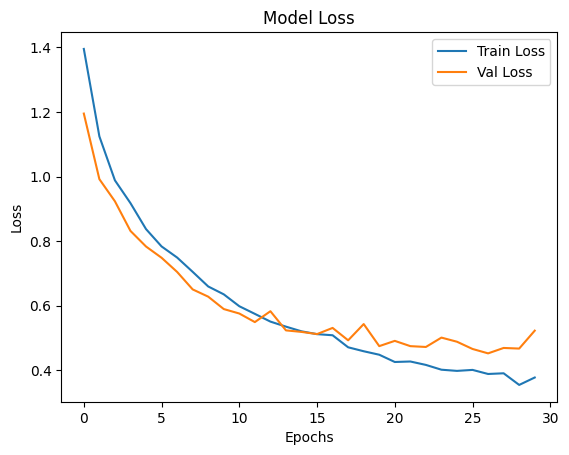

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('Loss_plot.png')
plt.show()

### Plotting the Accuracy Curve.

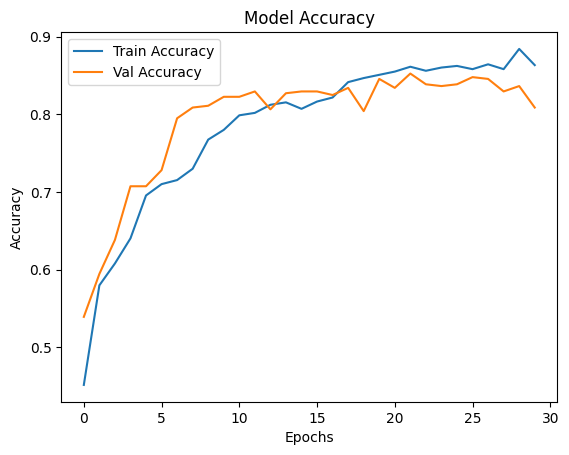

In [13]:

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('Accuracy_plot.png')
plt.show()

In [15]:
pose_labels

['downdog', 'goddess', 'plank', 'tree', 'warrior2']

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


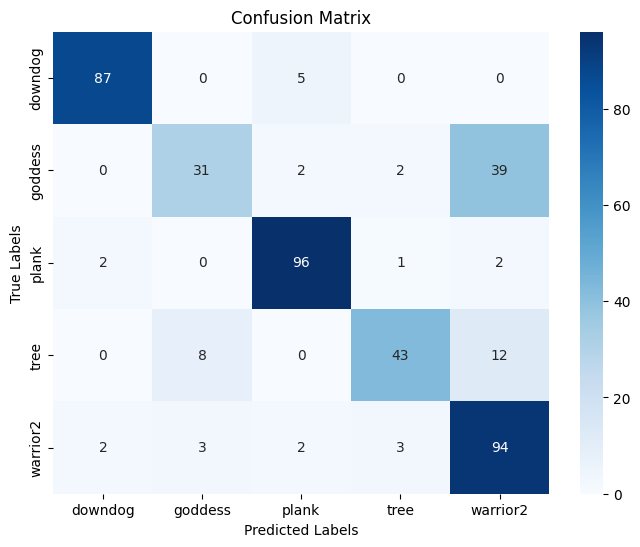

Classification Report:
              precision    recall  f1-score   support

     downdog       0.96      0.95      0.95        92
     goddess       0.74      0.42      0.53        74
       plank       0.91      0.95      0.93       101
        tree       0.88      0.68      0.77        63
    warrior2       0.64      0.90      0.75       104

    accuracy                           0.81       434
   macro avg       0.83      0.78      0.79       434
weighted avg       0.82      0.81      0.80       434



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pose_labels, yticklabels=pose_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig('confusion_matrix.png')
plt.show()
# Classification report for additional metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=pose_labels))

Overall Accuracy: The model achieves an accuracy of 81%, which indicates good general performance for multi-class yoga pose classification.


Strengths:


Performs exceptionally well on Downdog (F1-Score: 0.95) and Plank (F1-Score: 0.93) due to their distinct and consistent landmark features.


Weaknesses:
Struggles with Goddess pose (F1-Score: 0.53) due to low recall, suggesting misclassification and missed detections.  

Tree pose has moderate performance, with recall at 68%, possibly due to variability in pose execution.  

Warrior 2 has high recall but low precision, leading to false positives.  


Conclusions:
The model works well for poses with distinct landmark patterns.  

Requires improvement for poses with high variability or overlap with other poses.  







### Testing the model on a Random Image .

In [ ]:
# Example for a new image
new_image_path = '/content/images (1).jpg'

# Extract landmarks from the new image
landmarks = extract_landmarks(new_image_path)

if landmarks is not None:
    landmarks = landmarks.reshape(1, -1)  # Reshape for model prediction

    # Predict the yoga pose
    prediction = model.predict(landmarks)
    predicted_pose = pose_labels[np.argmax(prediction)]

    print(f"Predicted Pose: {predicted_pose}")
else:
    print("No landmarks detected.")

No landmarks detected.
